In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [26]:
X = load("GZZ_data.jld", "X")
y = load("GZZ_data.jld", "y")
ξ_true = load("GZZ_data.jld", "xi_true");

d, Nobs = size(X)
mb_size = Int(round(Nobs/10))
σ02 = 1
prior = NG_prior(d, σ02)
prior.λ_scale = 0.05
prior.λ_attempts = 100

100

In [27]:
my_ll = ll_logistic(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

In [28]:
# Sub-Sampling without control variate and with weights
ϵ = 1e-2
weights = abs.(X) + ϵ
weights ./= sum(weights,2)
gs = [wumbsampler(Nobs, mb_size, weights[i,:]) for i in 1:d]
gs_list = mbsampler_list(d,gs);

In [29]:
A = eye(d)

opf = projopf(A, 100, hyperparam_size(prior))
opt = maxa_opt(10^6)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list, zz_state(opf))
update_bound(bb, my_ll, prior, gs_list, zz_state(opf));

In [30]:
print("Initial speed = ", opf.alpha_skeleton[:,opf.tcounter+1])

Initial speed = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [31]:
adapt_speed = false
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1.)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [32]:
start = time()
ZZ_block_sample(my_model::model, outp::outputscheduler, blocksampler::Array{msampler})
print( round((time()-start)/60, 2), " mins")

10% attempts in 0.24 mins 
20% attempts in 0.47 mins 
30% attempts in 0.71 mins 
40% attempts in 0.95 mins 
50% attempts in 1.18 mins 
60% attempts in 1.42 mins 
70% attempts in 1.66 mins 
80% attempts in 1.9 mins 
90% attempts in 2.15 mins 
100% attempts in 2.4 mins 
2.4 mins

In [33]:
discard = 0
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear")[:,1:end-1];
hyp_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                              outp.opf.bt_skeleton[:,discard+1:end], 
                              outp.opf.bt_skeleton[end]/n_samples,
                              "constant")[:,1:end-1];

In [34]:
size(hyp_samples)

(51, 10000)

In [35]:
maxlag = 1000
acfs_xi = zeros(d, maxlag)
acfs_hyp = zeros(size(hyp_samples,1), maxlag)

for i in 1:d 
    acfs_xi[i,:] = acf(xi_samples[i,:], maxlag)
end
for i in 1:size(hyp_samples,1)
    acfs_hyp[i,:] = acf(hyp_samples[i,:], maxlag)
end

In [36]:
maximum(acfs_hyp[:,100])

0.2559524931654452

In [37]:
acfs_hyp[:,100]

51-element Array{Float64,1}:
 -0.00147964 
  0.00291708 
  0.00383363 
 -0.002519   
  0.021806   
  0.00693743 
  0.0157081  
  0.00822089 
 -0.00246033 
  0.037887   
 -0.00281846 
  0.0705151  
  0.0374568  
  ⋮          
  0.0061104  
  0.0234837  
  0.129494   
  0.000238698
  0.0972713  
  0.0340949  
  0.172327   
 -0.00101867 
  0.0305452  
  0.0112936  
  0.000297201
 -1.51732e-5 

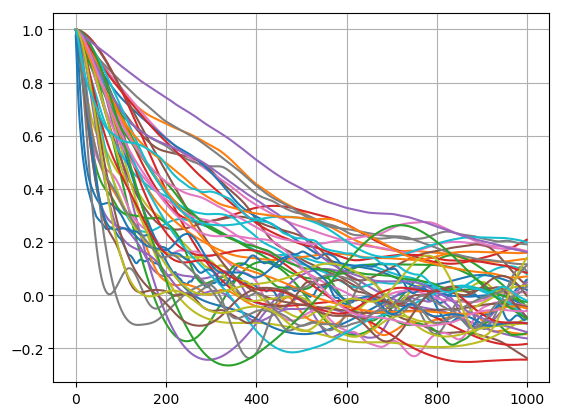

In [38]:
for i in 1:d 
    plot(acfs_xi[i,:])
end
grid(true)

In [43]:
cover = zeros(d)
ci = zeros(d,2)
for i in 1:d 
    ci[i,:] = percentile(xi_samples[i,:], [5, 95])
    cover[i] = (ci[i,1]<ξ_true[i])&(ξ_true[i]<ci[i,2])
end

In [44]:
100*mean(cover)

42.0

In [45]:
ci

50×2 Array{Float64,2}:
  -0.536399    1.78791 
 -19.5924     15.849   
 -33.8727      5.67365 
 -52.9883     -0.579064
   2.48957    15.279   
 -22.2605      4.26694 
  27.5325     72.945   
   4.80558    26.4975  
  -4.91709     8.57925 
 -11.1101     13.9629  
 -38.1185     -8.23372 
 -13.0631      1.29891 
  38.4805     91.5468  
   ⋮                   
 -36.3135      0.551289
 -79.5815    -23.6108  
 -14.043       1.36    
 -32.1757     -2.07875 
 -61.5506     -4.36788 
   3.05489    31.6829  
   8.88911    40.5801  
   3.65199    28.1688  
 -50.8522    -10.5759  
  -1.20547    10.965   
   5.12774    31.8852  
 -12.3294     -0.754898